# Imports

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


import numpy as np
import matplotlib.pyplot as plt
  
from sklearn.linear_model import LinearRegression

# Web Scraping

<font size='4'>*** This just creates the elo_data.csv and top_elo_data.csv so you don't need to run it ***</font>

In [2]:
# Retrieves all the URL's and names of Countries

URL = "https://footballdatabase.com/ranking/germany/1"
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")
countries = soup.find_all("option")[8:]
url_names = []
pretty_names = []
for country in countries:
    pretty_names.append(country.text)
    url_names.append(str(country).split('"')[1])

In [3]:
# Sends GET request for HTML and parses it for Team names and ELO ratings to Create Pandas DataFrame

team_df = []
for index, name in enumerate(url_names):
    URL = "https://footballdatabase.com" + name
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")

    ranks = soup.find_all("td", class_="rank")
    ranks = [rank.text for index, rank in enumerate(ranks) if index % 2 != 0]

    teams_html = soup.find_all("td", class_="club text-left")
    teams = []
    for team in teams_html:
        teams.append(team.find("div", class_="limittext").text)
    if len(ranks) != len(teams): # check if there is a team without a ELO or vice versa
        print("Error")
        print(ranks)
        print(teams)
        print(name)

    final_output = []
    for index2 in range(len(teams)):
        final_output.append([teams[index2], ranks[index2]]) # [['man city', 1942], ['team_name', 1454']]

    if 'Manchester City' in final_output[0] and pretty_names[index] != 'England': # some countries don't work and just default to the world list
        pass
    else:
        for pair in final_output:
            team_df.append([pretty_names[index], pair[0], pair[1]])

In [4]:
df = pd.DataFrame(team_df)
df.rename(columns={0: "country_name", 1: "team", 2: "elo"}, inplace=True)

In [5]:
df.to_csv("elo_data.csv", index=False)

In [6]:
elo_data_group = df[['country_name', 'elo']]
elo_data_group = elo_data_group.groupby(by='country_name').first().sort_values(by='elo', ascending=False)
elo_data_reset = elo_data_group.reset_index()
elo_data_reset.to_csv("top_elo_data.csv", index=False)

# Visualizations

<font size='4'>Top 10 vs Bottom 10</font>

In [7]:
elo_data = pd.read_csv("elo_data.csv")

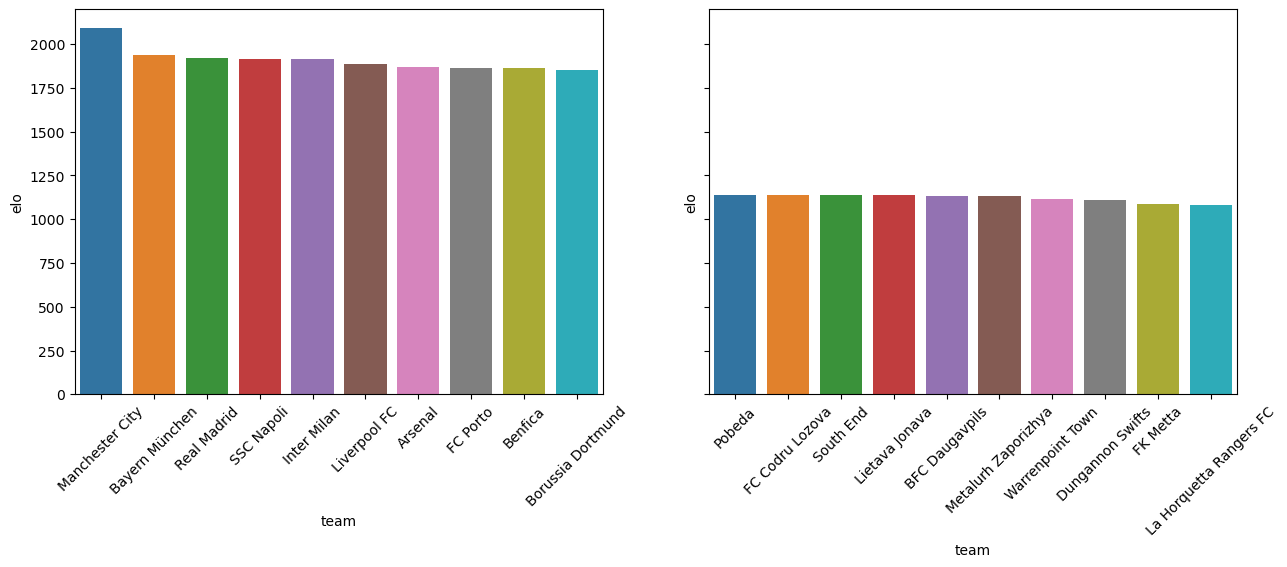

In [8]:
top_10 = elo_data.sort_values(by='elo', ascending=False).iloc[:10]
bottom_10 = elo_data.sort_values(by='elo', ascending=False).iloc[-10:]

fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
plot = sns.barplot(ax=axes[0], data=top_10, x='team', y='elo')
for item in plot.get_xticklabels():
    item.set_rotation(45)
plot2 = sns.barplot(ax=axes[1], data=bottom_10, x='team', y='elo')
for item in plot2.get_xticklabels():
    item.set_rotation(45)

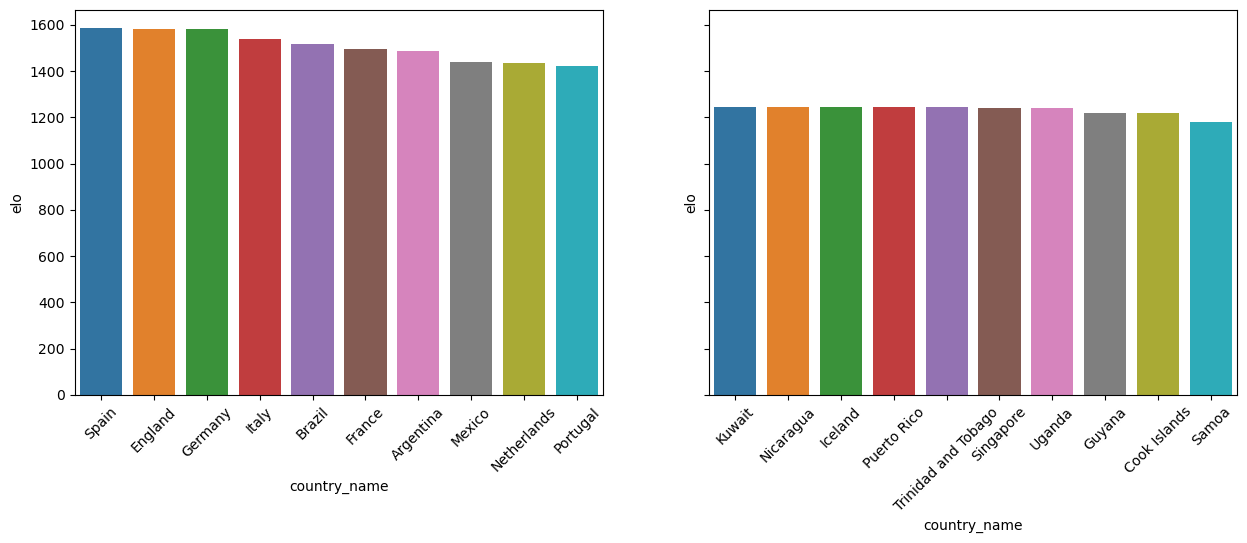

In [9]:
elo_data_group = elo_data[['country_name', 'elo']]
elo_data_group = elo_data_group.groupby(by='country_name').mean().sort_values(by='elo', ascending=False)
elo_data_group_top = elo_data_group.iloc[:10]
elo_data_group_bottom = elo_data_group.iloc[-10:]


fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
plot = sns.barplot(ax=axes[0], data=elo_data_group_top, x=elo_data_group_top.index, y='elo')
plot2 = sns.barplot(ax=axes[1], data=elo_data_group_bottom, x=elo_data_group_bottom.index, y='elo')
for item in plot.get_xticklabels():
    item.set_rotation(45)
for item in plot2.get_xticklabels():
    item.set_rotation(45)

<font size='5'>Correlation of ELO and Power_rating (World Cup results score)</font>

In [10]:
wc_df = pd.read_csv('world_cup_result.csv')

In [11]:
elo_data_reset = elo_data_group.reset_index()
merged_df = wc_df.merge(elo_data_reset, left_on='team', right_on='country_name')

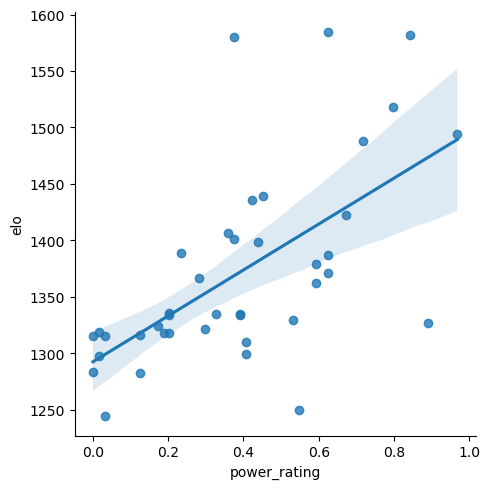

In [12]:
sns.lmplot(data=merged_df, y='elo', x='power_rating')

In [13]:
corr_df = merged_df[['elo', 'power_rating']]
corr_df.corr()

,elo,power_rating
elo,1.000000,0.613585
power_rating,0.613585,1.000000


Text(15.625000000000009, 0.5, "Top Domestic Team's ELO")

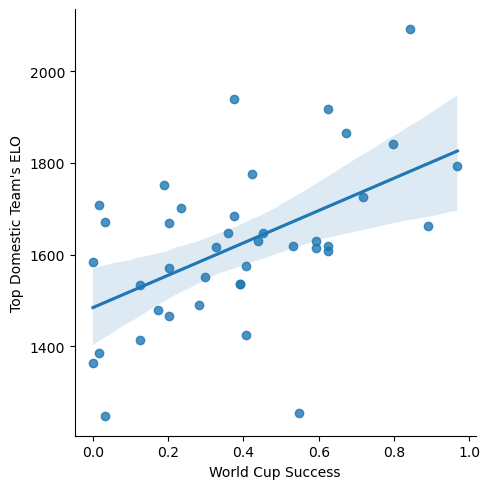

In [14]:
elo_data_group = elo_data[['country_name', 'elo']]
elo_data_group = elo_data_group.groupby(by='country_name').first().sort_values(by='elo', ascending=False)
elo_data_reset = elo_data_group.reset_index()
merged_df = wc_df.merge(elo_data_reset, left_on='team', right_on='country_name')
sns.lmplot(data=merged_df, y='elo', x='power_rating')
plt.xlabel('World Cup Success')
plt.ylabel('Top Domestic Team\'s ELO')

In [15]:
corr_df = merged_df[['elo', 'power_rating']]
corr_df.corr()

,elo,power_rating
elo,1.00000,0.52555
power_rating,0.52555,1.00000


<font size='5'>Outlier Analysis</font>

In [16]:
merged_df['power_rank'] = merged_df['power_rating'].rank(ascending=False)
merged_df['elo_rank'] = merged_df['elo'].rank(ascending=False)
merged_df['diff'] = merged_df.apply(lambda x : x['elo_rank'] - x['power_rank'], axis=1)
merged_df = merged_df.sort_values(by='diff', ascending=False)


In [17]:
x = merged_df['power_rating'].values.reshape(-1,1)
regression_model = LinearRegression()
regression_model.fit(x, merged_df['elo'])
p1 = np.array([0, float(regression_model.intercept_ + 0*regression_model.coef_)])
p2 = np.array([1, float(regression_model.intercept_ + 1*regression_model.coef_)])

def distance_func(power, elo):
    p3 = np.array([power, elo])
    return np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)


merged_df['distance'] = merged_df.apply(lambda x : distance_func(x['power_rating'], x['elo']), axis=1)
merged_df = merged_df.sort_values(by='distance', ascending=False)

In [18]:
merged_df['signed_dist'] = merged_df.apply(lambda x : x['distance'] if x['diff'] > 1 else -x['distance'], axis=1)
merged_df = merged_df.sort_values(by='signed_dist', ascending=False)
merged_df_top = merged_df[:3]
merged_df_bottom = merged_df[-3:]
final_df = pd.concat([merged_df_top, merged_df_bottom])
final_df

,Unnamed: 0,team,power_rating,country_name,elo,power_rank,elo_rank,diff,distance,signed_dist
30,30,Senegal,0.546875,Senegal,1255,12.0,39.0,27.0,1.197167,1.197167
16,16,Iceland,0.031250,Iceland,1247,35.5,40.0,4.5,0.704233,0.704233
1,1,Australia,0.406250,Australia,1424,17.5,35.0,17.5,0.577245,0.577245
11,11,Egypt,0.015625,Egypt,1709,37.5,10.0,-27.5,0.621661,-0.621661
12,12,England,0.843750,England,2093,3.0,1.0,-2.0,0.882595,-0.882595
14,14,Germany,0.375000,Germany,1940,21.5,2.0,-19.5,0.917422,-0.917422


Text(0, 0.5, 'Country')

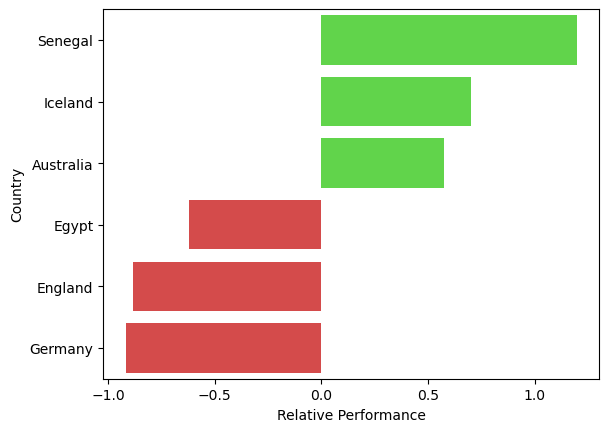

In [19]:
colors = ["#52eb34", "#52eb34", "#52eb34","#eb3434","#eb3434","#eb3434"]
sns.set_palette(sns.color_palette(colors))
sns.barplot(data=final_df, y='team', x='signed_dist')
plt.xlabel('Relative Performance')
plt.ylabel('Country')